In [22]:
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
from PIL import Image
import scipy.ndimage as ndimage
from scipy.ndimage.filters import convolve

In [24]:
"""def g_kernel(size, sigma=1):
    
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
"""

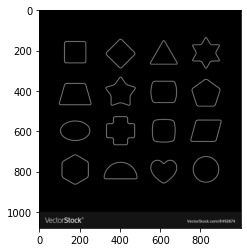

In [116]:
#loading the image
image=mping.imread('toy_image.jpg').astype('float64')
image=image/255.0
#plt.imshow(image)
#plt.show()
red_channel=image[:,:,0]
green_channel=image[:,:,1]
blue_channel=image[:,:,2]
lum_image=((0.2989*red_channel) + (0.5870*green_channel) + (0.1140*blue_channel))
#lum_image=convolve(lum_image, g_kernel(size=5, sigma=1))

#plt.imshow(image[:,:,2])
lum_image=cv2.GaussianBlur(lum_image,(5,5), 1 )
plt.imshow(lum_image,cmap=plt.get_cmap('gray'))
#plt.show()

In [47]:
# my_imfilter function
# my_imfilter.py file
def my_imfilter(image,filter):
	#filter_width,filter_height =filter.shape
  filter_width=filter.shape[0]
  filter_height=filter.shape[1]
  image_width=image.shape[0]
  image_height=image.shape[1]
	#image_width,image_height =image.shape
  padding_width=int ((filter_width-1)/2)
  padding_height=int ((filter_height-1)/2)
  new_width=image_width+2*padding_width
  new_height=image_height+padding_height*2
  padding_matrix=np.zeros(shape=(new_width,new_height))

  padding_matrix[padding_width: image_width + padding_width, padding_height : image_height + padding_height] = image
  output_image = image.copy()
  w=len(image)
  h=len(image[0])
  #n_channels =len(image[0][0])

  #for a in range(n_channels):
  for i in range(w):
    for j in range(h):
      output_image[i][j]=sum(sum(np.multiply(filter, padding_matrix[i:i+filter_width, j:j+filter_height])))
			  



  return output_image

In [48]:
def get_gradient(image):
  x_dir=np.asarray([[1,0,-1],[1,0,-1],[1,0,-1]],np.float64)
  y_dir=np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]],np.float64)
  gradient_x=ndimage.convolve(image,x_dir)
  gradient_y=ndimage.convolve(image,y_dir)
  magnitude_gradient=np.hypot(gradient_x,gradient_y)
  direction_gradient=np.arctan2(gradient_y,gradient_x)
  #print(magnitude_gradient.shape)

  return (direction_gradient,magnitude_gradient)



In [115]:
def suppression(gradient_image):
  direction_gradient,magnitude_gradient=gradient_image
  h=direction_gradient.shape[0]
  w=direction_gradient.shape[1]
  pi=np.pi
  suppressed_image=np.zeros_like(magnitude_gradient,np.float64)

  for i in range(h):
    for j in range (w):
      if (direction_gradient[i][j]<0):
        direction_gradient[i][j]=direction_gradient[i][j] + pi
      else:
        direction_gradient[i][j]=direction_gradient[i][j]
  
  for i in range(1,h-1):
    for j in range(1,w-1):
      if ((direction_gradient[i][j]<(pi/8) and direction_gradient[i][j]>=0) or (direction_gradient[i][j]>=((7*pi)/8) and direction_gradient[i][j]<=pi)):
        nb1=magnitude_gradient[i][j-1]
        nb2=magnitude_gradient[i][j+1]

      elif ((direction_gradient[i][j]<(3*pi/8) and direction_gradient[i][j]>=(pi/8))):
        nb1=magnitude_gradient[i+1][j-1]
        nb2=magnitude_gradient[i-1][j+1]
      
      elif ((direction_gradient[i][j]<(5*pi/8) and direction_gradient[i][j]>=(3*pi/8))):
        nb1=magnitude_gradient[i+1][j]
        nb2=magnitude_gradient[i-1][j]

      elif ((direction_gradient[i][j]<(7*pi/8) and direction_gradient[i][j]>=(5*pi/8))):
        nb1=magnitude_gradient[i-1][j-1]
        nb2=magnitude_gradient[i+1][j+1]

      if (magnitude_gradient[i][j]>=nb1 and magnitude_gradient[i][j]>=nb2):
        suppressed_image[i][j]=magnitude_gradient[i][j]

      else:
        suppressed_image[i][j]=0.00
  
  return suppressed_image

    



      

    
    




In [50]:
def get_threshold_matrices(sup_image,low_v,high_v):
  no_edge_matrix=np.zeros_like(sup_image,np.float64)
  weak_edge_matrix=np.zeros_like(sup_image,np.float64)
  strong_edge_matrix=np.zeros_like(sup_image,np.float64)
  threshold_matrix=np.zeros_like(sup_image,np.float64)
  h=sup_image.shape[0]
  w=sup_image.shape[1]
  low_v= low_v * (1.0000)
  high_v=high_v *(1.000)
  for i in range(h):
    for j in range(w):
      if (sup_image[i][j]>= high_v):
        strong_edge_matrix[i][j]=1
        threshold_matrix[i][j]=1

      elif (sup_image[i][j]<low_v):
        no_edge_matrix[i][j]=1

      elif ((sup_image[i][j]>=low_v) and (sup_image[i][j]<high_v)):
        weak_edge_matrix[i][j]=1
        threshold_matrix[i][j]=0.5

  
  return (no_edge_matrix,weak_edge_matrix,strong_edge_matrix,threshold_matrix)










In [51]:
def depth_for_search_prim(image,visited,i,j):
  if (i<0 or i>(image.shape[0]-1) or j<0 or j>(image.shape[1]-1)):
    return image,visited

  elif (visited[i][j]== 1):
    return image,visited

  visited[i][j]=1;

  if (image[i][j]==0):
    return image,visited

  image[i][j]=1.00

  count=8

  #for i in range(count):
  image,visited = depth_for_search_prim(image,visited,i+1,j+1)
  image,visited=depth_for_search_prim(image,visited,i+1,j)
  image,visited=depth_for_search_prim(image,visited,i+1,j-1)
  image,visited=depth_for_search_prim(image,visited,i,j+1)
  image,visited=depth_for_search_prim(image,visited,i,j-1)
  image,visited=depth_for_search_prim(image,visited,i-1,j+1)
  image,visited=depth_for_search_prim(image,visited,i-1,j)
  image,visited=depth_for_search_prim(image,visited,i-1,j-1)

  return image,visited


In [52]:
def depth_for_search_sec(image):
  visited = np.zeros_like(image,np.int64)

  h= image.shape[0]
  w=image.shape[1]
  
  for i in range(h):
    for j in range(w):
      if (image[i][j]==1 and visited[i][j]==0):
        image,visited=depth_for_search_prim(image,visited,i,j)

      else:
        continue

  for i in range(h):
    for j in range(w):
      if (image[i][j]!=1):
        image[i][j]=0

  
  return image


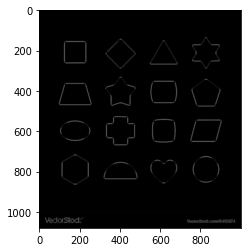

In [117]:
direction_gradient,magnitude_gradient= get_gradient(lum_image)
gradient_image=(direction_gradient,magnitude_gradient)
sup_image=suppression(gradient_image)
plt.imshow(sup_image,cmap=plt.get_cmap('gray'))
plt.show()

In [125]:
no_edge_matrix,weak_edge_matrix,strong_edge_matrix,threshold_matrix=get_threshold_matrices(sup_image,0.48,0.88)

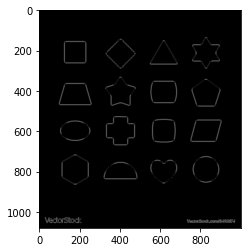

In [126]:
final_image=depth_for_search_sec(threshold_matrix)
plt.imshow(final_image,cmap=plt.get_cmap('gray'))
plt.show()

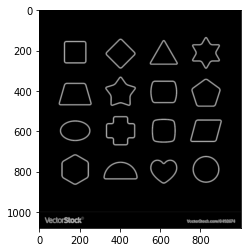

In [120]:
plt.imshow(magnitude_gradient,cmap=plt.get_cmap('gray'))
plt.show()

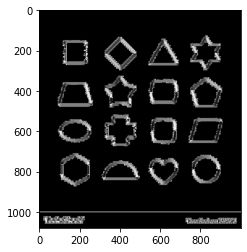

In [121]:
plt.imshow(direction_gradient,cmap=plt.get_cmap('gray'))
plt.show()

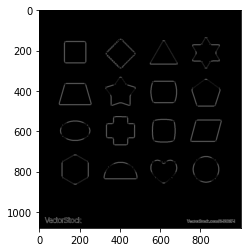

In [122]:
plt.imshow(threshold_matrix,cmap=plt.get_cmap('gray'))
plt.show()

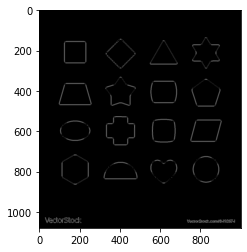

In [123]:
plt.imshow(strong_edge_matrix,cmap=plt.get_cmap('gray'))
plt.show()

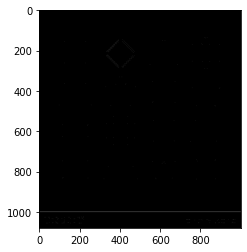

In [101]:
plt.imshow(weak_edge_matrix,cmap=plt.get_cmap('gray'))
plt.show()

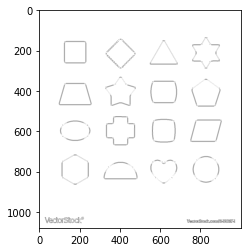

In [124]:
plt.imshow(no_edge_matrix,cmap=plt.get_cmap('gray'))
plt.show()